In [1]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd 


import torch.nn.functional as F

## Load data

In [2]:
#/Users/laurabraadrasmussen/Documents/UNI/5. semester/Deep Learning/Projekt/Data
train_data = pd.read_csv('../Data/training.csv')
test_data = pd.read_csv('../Data/test.csv')
id_lookup_data = pd.read_csv('../Data/IdLookupTable.csv')


In [34]:
test_data.iloc[1]

ImageId                                                    2
Image      76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
Name: 1, dtype: object

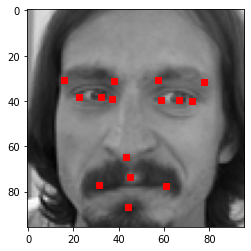

In [4]:
def get_image_and_keypoints(series):
    image = series['Image']
    image = np.fromstring(image, sep=' ').reshape([96, 96]) / 255.0
    keypoints = pd.DataFrame(series).drop(['Image'], axis=0).values.reshape([15, 2])
    return image, keypoints

def get_image_and_keypoints_by_id(train_data, id):
    series = train_data.iloc[id]
    return get_image_and_keypoints(series)


def show_image_with_keypoints(series):
    image, keypoints = get_image_and_keypoints(series)
    plt.imshow(image, cmap='gray')
    plt.plot(keypoints[:, 0], keypoints[:, 1], 'rs')


def show_image_with_keypoints_by_id(train_data, id):
    series = train_data.iloc[id]
    show_image_with_keypoints(series)
    
show_image_with_keypoints_by_id(train_data, 4)

## Data preprocessing

In [5]:
# Fjerner NA i dataset
train_data = train_data.dropna()
len(train_data)

2140

In [6]:
# 200 random samples
train_data_200 = train_data.sample(n = 200)

In [7]:
#train_data_200[:1].left_eye_center_x

In [8]:
#train_data_200.iloc[8]


## Model

In [9]:
x_coordinat = []
y_coordinat = []

for i in range(0,30,2):
    x_coordinat.append(train_data_200.iloc[1][i])
    y_coordinat.append(train_data_200.iloc[1][i+1])


In [10]:
#make data iterator for spiral dataset

class imageDataset(Dataset):
 
  def __init__(self, file_name):
    labels=[file_name.iloc[i].values[0:30] for i in range(len(train_data_200))]
    inputs=[file_name.iloc[i].values[30:31] for i in range(len(train_data_200))]
    
    inputs = [(i[0].split()) for i in inputs]
    inputs = [[int(i) for i in j] for j in inputs] 
    inputs = [np.reshape(i, (96,96)) for i in inputs]
    inputs = [np.expand_dims(i,0) for i in inputs]
    
    
    
    #print(inputs[0])
    #print(type(inputs[1]))
    self.labels=torch.tensor(labels,dtype=torch.float32) #convert to torch floats otherwise 
    self.inputs=torch.tensor(inputs, dtype=torch.float) #we will get an error message
 
  def __len__(self):
    return len(self.labels)
   
  def __getitem__(self, idx):
    return self.inputs[idx], self.labels[idx]
    



In [39]:
data = imageDataset(train_data_200)

In [37]:
batch_size = 100
#Convert to tensors
x_train = data.inputs
y_train = data.labels
x_test = torch.tensor(x_test_org)
y_test = torch.tensor(y_test_org)

trainset = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torch.utils.data.TensorDataset(x_test, y_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

NameError: name 'x_test_org' is not defined

In [25]:
input_shape = x_train[0].shape
print('input_shape :',input_shape)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
#print(x_test.shape[0], 'test samples')

# to_categorical converts class indices to one-hot vectors
print('y_train shape:', y_train.shape)

input_shape : torch.Size([1, 96, 96])
x_train shape: torch.Size([200, 1, 96, 96])
200 train samples
y_train shape: torch.Size([200, 30])


In [26]:
#%% make network
num_classes = 30


#something simple like cnn-cnn-fc-relu-fc will do

# define network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = torch.relu
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=256, kernel_size=3, padding='same')
        self.fc1 = nn.Linear(256*24*24, 1024)
        self.FC1 = nn.Linear(1024, 128)  
        self.FC2 = nn.Linear(128, num_classes)  
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
    
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        x = x.view(-1, 256*24*24)
        
        x = self.fc1(x)
        x = F.relu(x)
 
        
        x = self.FC1(x)
        x = F.relu(x)
        x = self.FC2(x)
        
        return x

net = NeuralNetwork()

In [27]:
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
#optimizer = optim.SGD(fcn.parameters(), lr=0.1)
optimizer = optim.Adam(net.parameters(), lr=0.1)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5) # decrease LR every two steps

nEpocs = 30 # How many times should we run over the data set?
totaliter = 0
net.train()
for epoch in range(nEpocs):  # loop over the dataset multiple times
    #print('epoch',epoch)
    running_loss = 0.0
    
    #scheduler.step()
    
    for i, data in enumerate(trainloader, 0):
        totaliter+=1
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize      
        outputs = net(inputs)
        outputs_reshape = outputs.view(outputs.shape[0],-1)
        loss = criterion(outputs_reshape, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        

    print('Epoch %d, Train loss: %.3f' %(epoch + 1, running_loss / 100))
            
    running_loss = 0.0
print('Finished Training')
net.eval()

Epoch 1, Train loss: 15227935397013.275
Epoch 2, Train loss: 1165768.951
Epoch 3, Train loss: 1384.805
Epoch 4, Train loss: 52.370
Epoch 5, Train loss: 52.292
Epoch 6, Train loss: 51.269
Epoch 7, Train loss: 48.228
Epoch 8, Train loss: 42.348
Epoch 9, Train loss: 33.381
Epoch 10, Train loss: 22.189
Epoch 11, Train loss: 11.494
Epoch 12, Train loss: 5.895
Epoch 13, Train loss: 6.808
Epoch 14, Train loss: 7.848
Epoch 15, Train loss: 5.147
Epoch 16, Train loss: 1.906
Epoch 17, Train loss: 0.933
Epoch 18, Train loss: 1.799
Epoch 19, Train loss: 2.875
Epoch 20, Train loss: 3.162
Epoch 21, Train loss: 2.568
Epoch 22, Train loss: 1.563
Epoch 23, Train loss: 0.769
Epoch 24, Train loss: 0.535
Epoch 25, Train loss: 0.673
Epoch 26, Train loss: 0.747
Epoch 27, Train loss: 0.598
Epoch 28, Train loss: 0.415
Epoch 29, Train loss: 0.393
Epoch 30, Train loss: 0.480
Finished Training


NeuralNetwork(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=147456, out_features=1024, bias=True)
  (FC1): Linear(in_features=1024, out_features=128, bias=True)
  (FC2): Linear(in_features=128, out_features=30, bias=True)
)

In [31]:
train_data_200.iloc[43]

left_eye_center_x                                                    63.844634
left_eye_center_y                                                    35.156458
right_eye_center_x                                                   33.368276
right_eye_center_y                                                   36.635917
left_eye_inner_corner_x                                              59.102897
left_eye_inner_corner_y                                              36.280452
left_eye_outer_corner_x                                              70.058152
left_eye_outer_corner_y                                              35.452337
right_eye_inner_corner_x                                             38.398676
right_eye_inner_corner_y                                             37.227674
right_eye_outer_corner_x                                             28.042593
right_eye_outer_corner_y                                             37.523553
left_eyebrow_inner_end_x                            

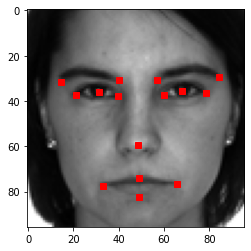

In [32]:
show_image_with_keypoints_by_id(train_data,1533)

[[61.43147278 37.06702805]
 [30.91736603 37.92211914]
 [55.42354202 38.21482086]
 [66.75011444 38.22518158]
 [37.61738205 38.49495316]
 [22.25114632 38.87945557]
 [54.14083481 29.73340416]
 [71.5452652  30.37964439]
 [40.06378174 30.24884224]
 [12.02650738 31.96216011]
 [46.98968887 55.1903038 ]
 [59.27669525 68.72192383]
 [33.95275879 68.34269714]
 [47.05810165 65.76344299]
 [47.96289062 74.50486755]]


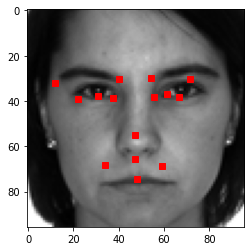

In [33]:

def get_image_and_keypoints2(series):
    image = series['Image']
    image = np.fromstring(image, sep=' ').reshape([96, 96]) / 255.0
    keypoints = pd.DataFrame(outputs[43].tolist()).values.reshape([15, 2])
    print(keypoints)
    return image, keypoints

def get_image_and_keypoints_by_id2(train_data, id):
    series = train_data.iloc[id]
    return get_image_and_keypoints2(series)


def show_image_with_keypoints2(series):
    image, keypoints = get_image_and_keypoints2(series)
    plt.imshow(image, cmap='gray')
    plt.plot(keypoints[:, 0], keypoints[:, 1], 'rs')


def show_image_with_keypoints_by_id2(train_data, id):
    series = train_data.iloc[id]
    show_image_with_keypoints2(series)
    
show_image_with_keypoints_by_id2(train_data, 1533)

## Predictions

In [54]:
image_lists = [np.array(list((map(int, test_data.iloc[i, -1].split(' '))))).reshape(96, 96) for i in range(len(test_data))]

In [87]:
test_images = [np.expand_dims(i,0) for i in image_lists]
test_outputs = [net(torch.Tensor(i)) for i in test_images]

[[61.35068512 36.60722351]
 [30.33607864 37.48955536]
 [55.34555054 37.78439331]
 [66.5987854  37.80083084]
 [37.18215561 38.06726456]
 [21.53564453 38.46703339]
 [53.98165131 29.11925888]
 [71.15730286 29.78436852]
 [39.6799736  29.64857864]
 [11.70649624 31.41255569]
 [46.74007034 55.04323959]
 [59.19847488 68.51399231]
 [33.42351151 68.03141785]
 [46.81594086 65.60764313]
 [47.71234894 74.00392914]]


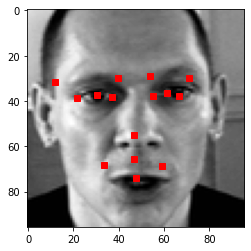

In [93]:
def get_image_and_keypoints2(series):
    image = series['Image']
    image = np.fromstring(image, sep=' ').reshape([96, 96]) / 255.0
    keypoints = pd.DataFrame(test_outputs[2].tolist()).values.reshape([15, 2])
    print(keypoints)
    return image, keypoints

def get_image_and_keypoints_by_id2(test_data, id):
    series = test_data.iloc[id]
    return get_image_and_keypoints2(series)


def show_image_with_keypoints2(series):
    image, keypoints = get_image_and_keypoints2(series)
    plt.imshow(image, cmap='gray')
    plt.plot(keypoints[:, 0], keypoints[:, 1], 'rs')


def show_image_with_keypoints_by_id2(train_data, id):
    series = train_data.iloc[id]
    show_image_with_keypoints2(series)
    
show_image_with_keypoints_by_id2(test_data, 2)